# Objective

Investigate ways to bound regions with many crowded spots. These bounds will allow us to effectively "zoom in" on these regions and generate crops of these regions.

- **Input:** Array of spot coordinates.
- **Output:** Bounding boxes for regions with many crowded spots.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.cluster import AffinityPropagation

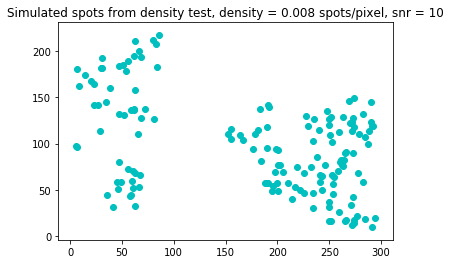

In [2]:
coords = np.genfromtxt('coords.csv', delimiter=',')
for coord in coords:
    plt.scatter(coord[0], coord[1], facecolors = 'c')
plt.title('Simulated spots from density test, density = 0.008 spots/pixel, snr = 10')
plt.show()

## Earlier (outdated) approach
1. Identify all crowded spots. Crowded spots have at least n neighbors within an m-pixel radius.
2. Separate regions with many crowded spots.
3. Define a bounding box around each region with many crowded spots.

Aborted at Step 1 because I realized the way this finds crowded regions doesn't directly address the limiting pixel distance associated with crosshair arm length.

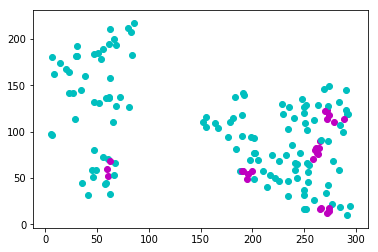

In [3]:
kdt = KDTree(coords, leaf_size=2, metric='euclidean')

def in_crowd(max_dist, min_num_neighbors, coord, kdt):
    dist, ind = kdt.query([coord], k=min_num_neighbors+1)
    distance_list = dist[0]
    return max(distance_list) <= max_dist

max_dist = 10           # m
min_num_neighbors = 4   # n

for coord in coords:
    if in_crowd(max_dist, min_num_neighbors, coord, kdt):
        plt.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'c')
plt.show()

# Current approach
1. Identify all crowded spots. Crowded spots are less than a crosshair arm length from the nearest neighbor.
2. Separate regions with many crowded spots.
3. Define a bounding box around each region with many crowded spots.

## Goal 1: Identify crowded spots.

Highlight spots which are too close to (i.e. less than an crosshair arm length from) the nearest neighbor. 

#### Min distance between two spots = crosshair arm length, relative to image width

There's a minimum distance between two spots for the crosshair mark left on one spot to not obscure the other spot. This minimum distance is the length of one arm of a crosshair. This minimum distance is in proportion with the pixel width of the image, since in Quantius the crosshairs take up the same proportion of the image regardless of image size.

Measuring by hand, I found the crosshair to image width ratio to be about 7:115, or 0.0609. Therefore one crosshair arm length is 0.03045 times the image width, so spots should be at least that far apart.

**"Crowded spots"** are spots which are less than a crosshair arm's length from the nearest neighbor.

crosshair_arm_length = 9.135
crowded spots / total spots = 117 / 156 = 0.75 %


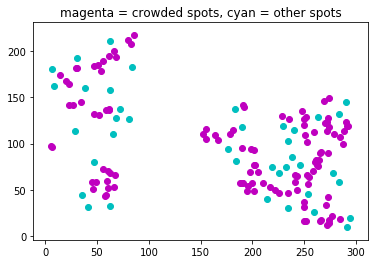

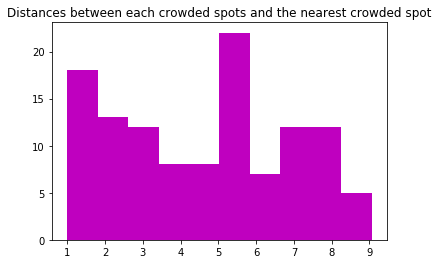

In [4]:
def get_nnd(coord, kdt):
    dist, ind = kdt.query([coord], k=2)
    return dist[0][1]

crosshair_arm_to_image_width_ratio = 0.03045   # measured empirically in Quantius's UI
image_width = 300
crosshair_arm_length = crosshair_arm_to_image_width_ratio * image_width
print('crosshair_arm_length = ' + str(crosshair_arm_length))

close_distances = []
crowded_spots = []
for coord in coords:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        close_distances.append(nnd)
        crowded_spots.append(coord)
        plt.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'c')

print('crowded spots / total spots = ' + str(len(crowded_spots)) + ' / ' + str(len(coords)) + ' = ' + str(round((float(len(crowded_spots))/len(coords)), 2)) + ' %')
        
plt.title('magenta = crowded spots, cyan = other spots')
plt.show()
plt.hist(close_distances, color = 'm')
plt.title('Distances between each crowded spots and the nearest crowded spot')
plt.show()

## Goal 2: Separate regions with many crowded spots.

Use AffinityPropagation on crowded spots to separate out regions with many crowded spots. Smaller preference parameter results in fewer separated regions.

In [5]:
pref_param = -50000
crowded_coords = np.asarray(crowded_spots)
af = AffinityPropagation(preference = pref_param).fit(crowded_coords)
cluster_centers_indices = af.cluster_centers_indices_
centers = [crowded_coords[index] for index in af.cluster_centers_indices_]
print(centers)

[array([250.,  37.]), array([190.,  95.]), array([ 54., 178.]), array([49., 58.]), array([272., 113.])]


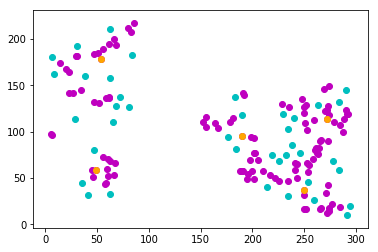

In [6]:
for coord in coords:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        plt.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'c')
for center in centers:
    plt.scatter(center[0], center[1], facecolors = 'orange')
plt.show()

## Goal 3: Define a bounding box around each region with many crowded spots.

In [7]:
cluster_members_lists = [[] for i in range(len(centers))]
for label_index, coord in zip(af.labels_, crowded_coords):
    cluster_members_lists[label_index].append(coord)

crop_bounds = []
for l in cluster_members_lists:
    l = np.asarray(l)
    x = l[:,0]
    y = l[:,1]
    crop_bounds.append((min(x), max(x), min(y), max(y)))
print(crop_bounds)

[(217.0, 284.0, 12.0, 70.0), (152.0, 210.0, 49.0, 142.0), (14.0, 86.0, 131.0, 217.0), (6.0, 67.0, 43.0, 97.0), (228.0, 292.0, 76.0, 149.0)]


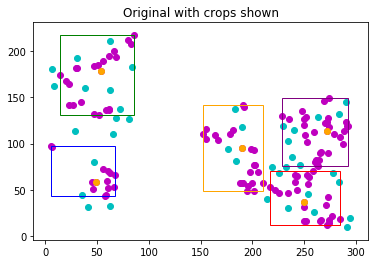

In [8]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots(1)
for coord in coords:
    nnd = get_nnd(coord, kdt)
    if nnd < crosshair_arm_length:
        ax.scatter(coord[0], coord[1], facecolors = 'm')
    else:
        ax.scatter(coord[0], coord[1], facecolors = 'c')
for center in centers:
    plt.scatter(center[0], center[1], facecolors = 'orange')

colors = ['red', 'orange', 'green', 'blue', 'purple']
for crop, col in zip(crop_bounds, colors):
    rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor = col, facecolor = 'none')
    ax.add_patch(rect)
plt.title('Original with crops shown')
plt.show()

## Analyze each crop seperately to see whether spots are now spaced far enough apart.

On scatter plots, spots closer to nearest neighbor than the width of a crosshair arm are marked in magenta.

-------------------------------------------------
Crop 0
crosshair_arm_length = 2.04015
crowded spots / total spots = 4 / 31 = 0.13 %


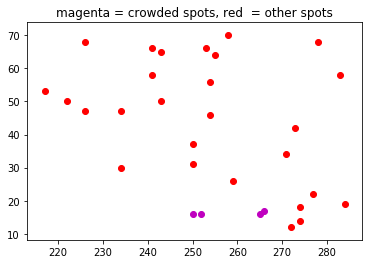

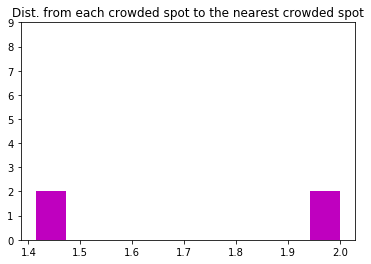

-------------------------------------------------
Crop 1
crosshair_arm_length = 1.7661
crowded spots / total spots = 4 / 28 = 0.14 %


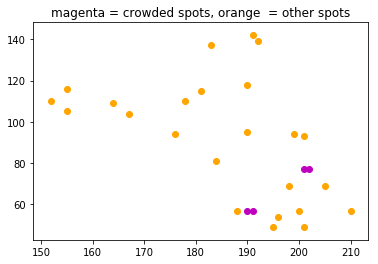

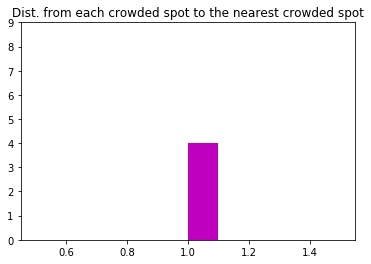

-------------------------------------------------
Crop 2
crosshair_arm_length = 2.1924
crowded spots / total spots = 4 / 29 = 0.14 %


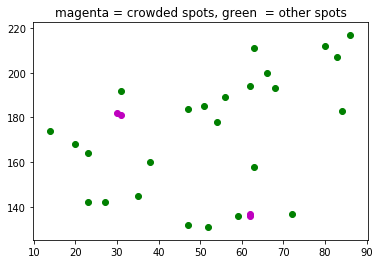

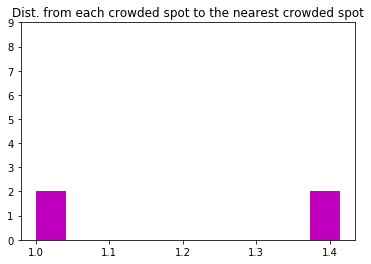

-------------------------------------------------
Crop 3
crosshair_arm_length = 1.85745
crowded spots / total spots = 2 / 16 = 0.12 %


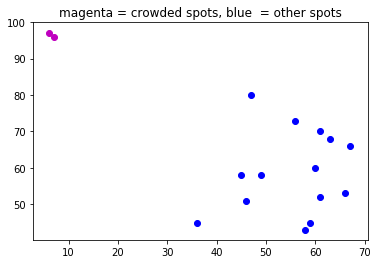

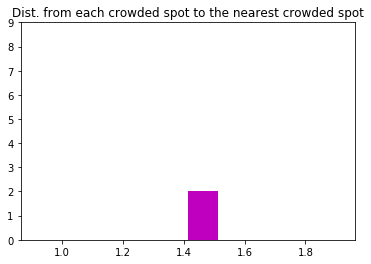

-------------------------------------------------
Crop 4
crosshair_arm_length = 1.9488
crowded spots / total spots = 6 / 39 = 0.15 %


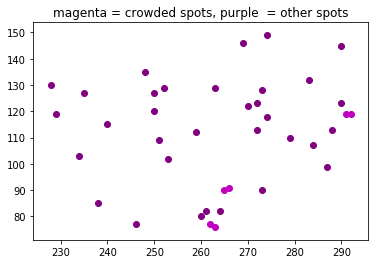

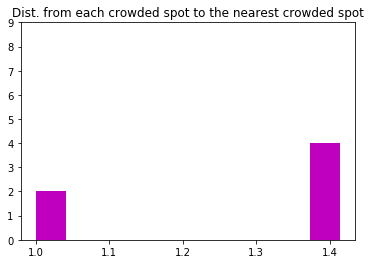

In [9]:
for i in range(len(crop_bounds)):
    print('-------------------------------------------------')
    print('Crop ' + str(i))
    
    crop = crop_bounds[i]
    col = colors[i]
    xmin = crop[0]
    xmax = crop[1]
    ymin = crop[2]
    ymax = crop[3]
    crop_width = crop[1]-crop[0]
    crosshair_arm_length = crosshair_arm_to_image_width_ratio * crop_width
    print('crosshair_arm_length = ' + str(crosshair_arm_length)) 
    
    crop_coords = []
    for coord in coords:
        if coord[0] >= xmin and coord[0] <= xmax:
            if coord[1] >= ymin and coord[1] <= ymax:
                crop_coords.append(coord)
                
    crop_kdt = KDTree(crop_coords, leaf_size=2, metric='euclidean')
    
    close_distances = []
    crowded_spots = []
    for coord in crop_coords:
        nnd = get_nnd(coord, crop_kdt)
        if nnd < crosshair_arm_length:
            close_distances.append(nnd)
            crowded_spots.append(coord)
            plt.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            plt.scatter(coord[0], coord[1], facecolors = col)
    
    print('crowded spots / total spots = ' + str(len(crowded_spots)) + ' / ' + str(len(crop_coords)) + ' = ' + str(round((float(len(crowded_spots))/len(crop_coords)), 2)) + ' %')
    
    plt.title('magenta = crowded spots, ' + str(col) + '  = other spots')
    plt.show()
    plt.hist(close_distances, color = 'm')
    plt.yticks(np.arange(0, 10, step=1))
    plt.title('Dist. from each crowded spot to the nearest crowded spot')
    plt.show()

# Next Steps

### The plot 'Original with crops shown' brings up some questions:
 - Do we want crop boxes to be squares?
     - If yes, we want bounds around coordinates to be squares or just resultant images to be squares?
     - If yes, do we want to shrink or grow the rectangles to make them squares?
 - In cases such as the blue box with stray but included points, do we want to try to exclude those stray points?
 - Some cyan (non-crowded) points are left out of the crop boxes. Do we want to extend the crop boxes to fit these spots or neglect them and stipulate that they must be found through a first pass annotating of the original image?

### To investigate:
 - Ways to automate setting the preference parameter for AffinityPropagation